In [1]:
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

print(train_data.shape)
print(test_data.shape)

# train_targets # 주택의 중간 가격, 1000$ 단위

57026/57026 [==============================] - 0s 0us/step
(404, 13)
(102, 13)


In [3]:
# 데이터 정규화하기 (여기서 하는 건 표준화임)
# 데이터가 어떻게 생겼는지 뜯어보는 게 중요한데, 여기선 그냥 생략함. 특성마다 스케일이 다르기 때문에 정규화를 해준다.

mean = train_data.mean(axis = 0) # 각 세로축의 평균 값을 구함
train_data -= mean

std = train_data.std(axis = 0) # 각 세로축의 표준편차를 구함
train_data /= std

test_data -= mean
test_data /= std

In [4]:
# 모델 구성
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation = 'relu'),
      layers.Dense(64, activation = 'relu'),
      layers.Dense(1),

  ])
  model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
  return model

In [5]:
# k-fold cv
# 사실 k-fold cv를 하려면, 데이터세트를 훈련/검증으로 나눔 -> 훈련셋의 평균, 표준편차를 구해서 표준화함 -> 검증셋에도 훈련셋의 평균,표준편차로 표준화함
# 이어야 하며, 이는 사이킷런의 `Pipeline` 클래스로 쉽게 구현할 수 있다.

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print("fold : ", i)

  # 이번 검증 데이터 : k = i
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

  # 원래 데이터에서 일부를 검증으로 뺐으니까 나머지 데이터를 합쳐서 훈련 데이터라고 함
  partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i+1)* num_val_samples:]], axis = 0
  )
  partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis = 0
  )

  # k번째 fold 마다 모델을 새로 만듦 : 당연한거임 가중치 초기화해야 하니까
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 16, verbose = 0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)

  all_scores.append(val_mae)

fold :  0
fold :  1
fold :  2
fold :  3


In [6]:
np.mean(all_scores)

2.3629761934280396

In [7]:
# 500 에포크 훈련 & 저장
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print("fold : ", i)

  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i+1)* num_val_samples:]], axis = 0
  )
  partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis = 0
  )

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 16, verbose = 0, validation_data = (val_data, val_targets))

  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

fold :  0
fold :  1
fold :  2
fold :  3


In [8]:
# 모든 폴드 MAE 평균 계산
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

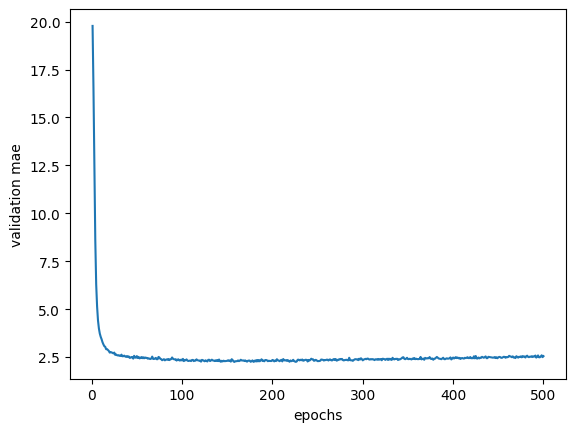

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("epochs")
plt.ylabel("validation mae")
plt.show()

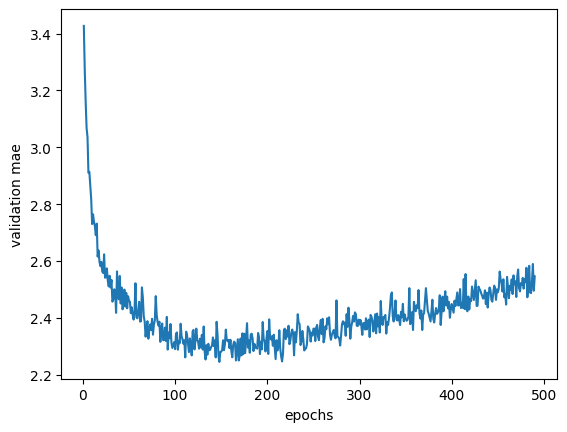

In [11]:
# 초기 에포크 제외 : 초기 MAE가 너무 커서 보기 힘들기 때문에
plt.plot(range(1, len(average_mae_history[10:]) + 1), average_mae_history[10:])
plt.xlabel("epochs")
plt.ylabel("validation mae")
plt.show()

In [12]:
# 최종 모델 훈련 - 위 그림을 보고, mae가 다시 증가하기 시작하는 지점까지만 에포크를 돌린다.
model = build_model()
model.fit(train_data, train_targets, epochs = 130, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

4/4 [==============================] - 0s 4ms/step - loss: 17.6168 - mae: 2.6364
2.6364331245422363


In [13]:
# 예측
test_mae_score

2.6364331245422363